Epochs: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


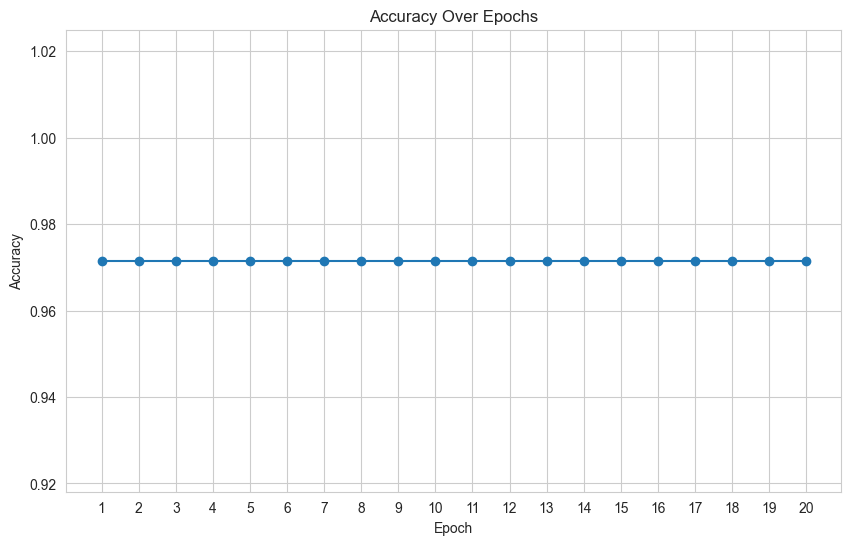

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     21903
           1       0.00      0.00      0.00       641

    accuracy                           0.97     22544
   macro avg       0.49      0.50      0.49     22544
weighted avg       0.94      0.97      0.96     22544

Accuracy: 0.9715223562810504


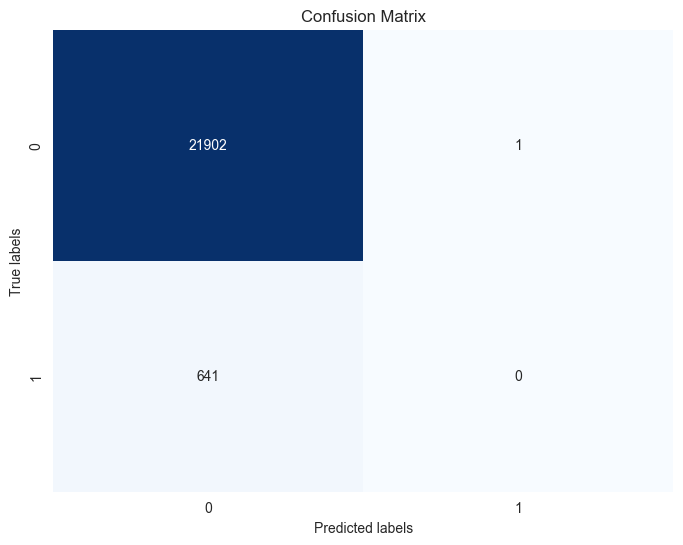

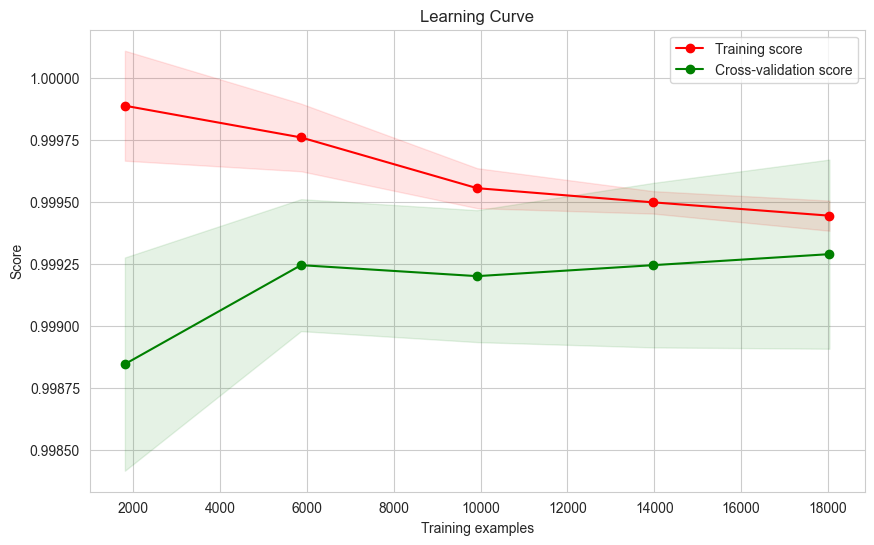

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from tqdm import tqdm

# Step 1: Data Preparation (This part will be done locally on each entity)
def load_and_preprocess_data(data_file, target_column, columns=None):
    """Loads dataset and preprocesses it."""
    # Read the dataset
    data = pd.read_csv(data_file)

    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # One-hot encode categorical features
    X = pd.get_dummies(X)

    # Use specified columns if provided
    if columns is not None:
        X = X.reindex(columns=columns, fill_value=0)  # Fill missing columns with zeros
    else:
        # Add missing columns from training data
        missing_columns = set(training_columns) - set(X.columns)
        for col in missing_columns:
            X[col] = 0

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Step 2: Model Initialization
def initialize_model():
    """Initializes a Logistic Regression model."""
    return LogisticRegression(max_iter=10000)  # Increase max_iter

# Step 3: Local Model Training with Differential Privacy
def train_local_model_with_dp(model, X_train, y_train, epsilon):
    """Trains a local model with differential privacy."""
    # Add noise to gradients (Differential Privacy)
    n, m = X_train.shape
    sensitivity = 1.0  # Sensitivity of the loss function
    beta = sensitivity / (n * epsilon)
    noise = np.random.laplace(0, beta, m)
    model.fit(X_train, y_train, sample_weight=1.0 / n)
    model.coef_ += noise.reshape(model.coef_.shape)
    return model

# Step 4: Model Aggregation
def aggregate_models(models):
    """Aggregates models by averaging their parameters."""
    return models[0]  # For logistic regression, we don't need aggregation

# Step 5: Evaluation
def evaluate_model(model, X_test, y_test):
    """Evaluates the model's performance."""
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_test, y_test, cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


# Main Federated Learning Loop with Differential Privacy
def federated_learning_with_dp(data_files, target_column, training_columns=None, epsilon=1.0, NUM_EPOCHS=20):
    # Load and preprocess data locally on each entity
    local_datasets = [load_and_preprocess_data(file, target_column, training_columns) for file in data_files]

    # Initialize local models
    local_models = [initialize_model() for _ in range(len(data_files))]

    # Lists to store evaluation metrics for each epoch
    accuracies = []

    # Federated learning loop
    for epoch in tqdm(range(NUM_EPOCHS), desc='Epochs', colour='green'):
        # Local training with differential privacy
        for i, (X_train, y_train) in enumerate(local_datasets):
            local_models[i] = train_local_model_with_dp(local_models[i], X_train, y_train, epsilon)

        # Aggregate models
        aggregated_model = aggregate_models(local_models)

        # Distribute aggregated model to local models
        for i in range(len(local_models)):
            local_models[i] = aggregated_model

        # Evaluate final aggregated model
        X_test, y_test = load_and_preprocess_data(data_files[0], target_column, training_columns)
        y_pred = aggregated_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_EPOCHS + 1), accuracies, marker='o', linestyle='-')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, NUM_EPOCHS + 1))
    plt.grid(True)
    plt.show()

    # Evaluate final aggregated model and plot confusion matrix
    evaluate_model(aggregated_model, X_test, y_test)

# Configuration
DATA_FILES = ['Test_data.csv', 'Train_data.csv']  # Example data files for each entity
TEST_DATA_FILE = 'Test_data.csv'  # Test data file
TARGET_COLUMN = 'is_guest_login'  # Specify the name of the target column
TRAINING_DATA_FILE = 'Train_data.csv'  # Training data file
training_data = pd.read_csv(TRAINING_DATA_FILE)
training_columns = pd.get_dummies(training_data.drop(TARGET_COLUMN, axis=1)).columns.tolist()

# Run federated learning with differential privacy
federated_learning_with_dp(DATA_FILES, TARGET_COLUMN, training_columns, epsilon=0.1)  # Adjust epsilon as needed
